In [102]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import gspread
from oauth2client.service_account import ServiceAccountCredentials
LEN = 1804

# Website parse and GoogleSheets update

In [103]:
HEADERS = {'user-agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36" }

In [104]:
def get_HTML(URL, params = None):
    r = requests.get(URL, headers = HEADERS, params = params)
    return r
# BeautifulSoup(get_HTML("https://www.tinkoff.ru/invest/currencies/").text)

In [105]:
# def parse_currencies(URL):
def curr_parser
    curr_dict = {}
    html = get_HTML("https://www.tinkoff.ru/invest/currencies/")
    if html.status_code == 200:
        soup = BeautifulSoup(html.text, "html.parser")
        items = soup.find_all("div",class_ = "SecurityColumn__cellPriceSecurities_cswKs")
        curr_dict["$"] = items[0].text.replace(",",".").replace("\xa0₽","")
        curr_dict["€"] = items[0].text.replace(",",".").replace("\xa0₽","")
        curr_dict["₽"] = 1
    else:
            print("Error")
    return curr_dict

SyntaxError: invalid syntax (<ipython-input-105-dc6f6f9a90be>, line 2)

In [106]:
def stock_parse(URL,Len):
    stock_params_dict = {}
    html = get_HTML(URL)
    if html.status_code == 200:
        soup = BeautifulSoup(html.text, "html.parser")
        items = soup.find_all("a", class_ = "Link-module__link__Wv1b Link-module__link_theme_default_gf5wq")
        
        stock_title_list = pd.Series([item.find('div', class_ = "Caption__caption_cyYZT") \
                         for item in items if item.find('div', class_ = "Caption__caption_cyYZT") ]).apply(lambda i: i.text)
        stock_ticker_list = pd.Series([item.find('div', class_ = "Caption__subcaption_xTAKS") \
                         for item in items if item.find('div', class_ = "Caption__subcaption_xTAKS") ]).apply(lambda i: i.text)
        stock_price_list = [price.replace("\xa0","") for price in pd.Series([item.find('div', class_ = "SecurityColumn__cellPriceSecurities_cswKs") \
                         for item in items if item.find('div', class_ = "SecurityColumn__cellPriceSecurities_cswKs") ]).apply(lambda i: i.text)]
        stock_yield_listok = pd.Series([item.find('span', class_ = "Money-module__money_UwC2N") \
                         for item in items if item.find('span', class_ = "Money-module__money_UwC2N") ]).apply(lambda i: i.text)
        stock_yield_list = [yld.replace("\xa0","") for yld in stock_yield_listok[::2]]
        for i in range(Len):
            stock_params_dict[stock_title_list[i]] = [stock_ticker_list[i],stock_price_list[i], stock_yield_list[i] ]
    else:
        print("Error")
    return  stock_params_dict


In [107]:
data = stock_parse("https://www.tinkoff.ru/invest/stocks/?country=All&orderType=Asc&sortType=ByName&start=0&end=" + str(LEN), LEN)

In [108]:
def struct(data):
    all_df = np.transpose(pd.DataFrame(data))
    all_df.columns = ["Ticker","Price","Nom_Yield"]
    all_df["Currency"] = all_df["Nom_Yield"].apply(lambda i: i[-1])
    all_df["Nom_Yield"] = all_df["Nom_Yield"].apply(lambda i: float(i.replace("+","").replace("−","-").replace(",",".")[:-1]))
    all_df["Price"] = all_df["Price"].apply(lambda i: float(i.replace(",",".")[:-1]))
    all_df["Yield_rate"] = (all_df["Price"] / (all_df["Price"] - all_df["Nom_Yield"])).apply(lambda i: round(i, 2) - 1)
    return all_df


In [109]:
df = struct(data)
credentials = ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('test-333300-1860a35c4df3.json', scope)
gc = gspread.authorize(credentials)

In [110]:
ws = gc.open("test").get_worksheet(0)
df = df.where(df.notna(), None)
ws.update([df.columns.values.tolist()] + df.values.tolist())

{'spreadsheetId': '1XIARKYc4ANNUEXr84YZdkKAthzVKUyJQl3_1bpWe5gs',
 'updatedRange': 'Sheet_1!A1:E1802',
 'updatedRows': 1802,
 'updatedColumns': 5,
 'updatedCells': 9008}

# API stock list

In [111]:
import tinvest
from secrets import TOKEN
from dev import export_portfolio

In [112]:
client = tinvest.SyncClient(TOKEN)

In [113]:
api_stocks_df = pd.DataFrame(list(map(lambda x: x.__dict__, client.get_market_stocks().payload.instruments)))
api_stocks_df

,currency,figi,isin,lot,min_price_increment,name,ticker,type,min_quantity
0,Currency.usd,BBG000HLJ7M4,US45867G1013,1,0.01,InterDigItal Inc,IDCC,InstrumentType.stock,NaN
1,Currency.usd,BBG002293PJ4,US74967X1037,1,0.01,RH,RH,InstrumentType.stock,NaN
2,Currency.usd,BBG000BH0FR6,US81181C1045,1,0.01,Seagen Inc.,SGEN,InstrumentType.stock,NaN
3,Currency.usd,BBG004MN1R41,US63938C1080,1,0.01,Navient,NAVI,InstrumentType.stock,NaN
4,Currency.usd,BBG000BWS3F3,US9746371007,1,0.01,Winnebago Industries Inc,WGO,InstrumentType.stock,NaN
...,...,...,...,...,...,...,...,...,...
1855,Currency.rub,BBG002W2FT69,RU000A0JS5T7,10,0.5,АбрауДюрсо,ABRD,InstrumentType.stock,NaN
1856,Currency.usd,BBG000BWJFZ4,US1252691001,1,0.01,CF Industries Holdings,CF,InstrumentType.stock,NaN
1857,Currency.usd,BBG000R1H6P8,US2103731061,1,0.01,Constellation Pharmaceuticals,CNST,InstrumentType.stock,NaN
1858,Currency.usd,BBG005BT60Y8,US62945V1098,1,0.01,NV5 Global Inc,NVEE,InstrumentType.stock,NaN


In [114]:
URL = "https://www.tinkoff.ru/api/trading/stocks/list?sessionId=4a0396b1f83b656805c970910441225f.ds-prod-api111&appName=web&appVersion=1.168.0&origin=web"

<!DOCTYPE html>
<html class="no-js" lang="ru">
<head>
<meta charset="UTF-8">
<link rel="canonical" href="/invest/stocks/" data-meta-dynamic="true">
<meta name="description" content="Купите акции компаний различных отраслей по текущему курсу онлайн 📊. Актуальные цены покупки и продажи акций на 26.11.2021, графики динамики котировок, прогнозы и рекомендации, идеи для инвестирования, новости компаний." data-meta-dynamic="true">
<title data-meta-dynamic="true">Купить акции компаний онлайн📈 | Тинькофф Инвестиции</title>
<meta property="og:title" content="Каталог акций | Тинькофф Инвестиции" data-meta-dynamic="true">
<meta property="og:description" content="Покупайте ценные бумаги и оплачивайте их картой прямо на Tinkoff.ru" data-meta-dynamic="true">
<meta property="og:site_name" content="Тинькофф Банк" data-meta-dynamic="true">
<meta property="og:image" content="https://acdn.tinkoff.ru/static/pages/files/9e230787-ab8b-4f3d-b787-78cb060bd20e.jpeg" data-meta-dynamic="true">
<meta property="og
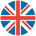
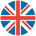

In [115]:
with requests.Session() as session:
    soup = BeautifulSoup(session.get("https://www.tinkoff.ru/invest/stocks/").text)
    print(session.get("https://www.tinkoff.ru/invest/stocks/").text)